In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.dummy import DummyRegressor
import prepare
from sklearn.linear_model import Ridge,Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

Section 1

In [2]:
dataset = pd.read_csv("virus_labeled.csv")

np.random.seed(1)

train, test = train_test_split(dataset, test_size=0.20, random_state=13)

prepared_test, prepared_test_target = prepare.prepare_data(test, train, bloodtype_to_binary=False)
prepared_train, prepared_train_target = prepare.prepare_data(train, train, bloodtype_to_binary=False)

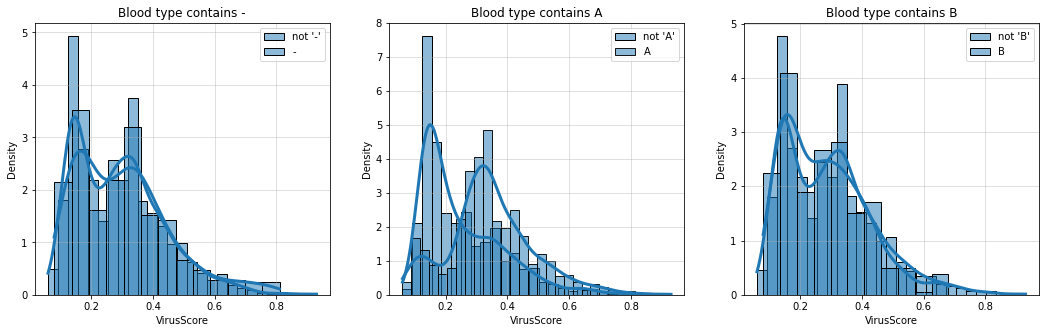

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
for i, cur_type in enumerate(['-', 'A', 'B']):
    filter_mask = prepared_train['blood_type'].str.contains(cur_type)
    not_plot = sns.histplot(data=prepared_train_target[~filter_mask], ax=ax[i], stat="density", kde=True,
    line_kws={"linewidth": 3}, palette=['red'], label="not '{}'".format(cur_type))
    sns.histplot(data=prepared_train_target[filter_mask], ax=ax[i], stat="density", kde=True,
    line_kws={"linewidth": 3}, palette=['orange'], label=cur_type)
    ax[i].set_title("Blood type contains " + cur_type)
    ax[i].legend(), ax[i].grid(alpha=0.5)

plt.show()

In [4]:
prepared_test, prepared_test_target = prepare.prepare_data(test, train)
prepared_train, prepared_train_target = prepare.prepare_data(train, train)

Section 2

In [5]:
class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        elif not isinstance(X,np.ndarray):
            X = np.array(X)
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        elif not isinstance(y,np.ndarray):
            y = np.array(y)
        n_samples, n_features = X.shape
        loss = np.linalg.norm(X.dot(w) + np.ones(n_samples) * b - y)**2 / n_samples

        return loss

    @staticmethod
    def gradient(w, b: float, X_, y_):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """

        # TODO: calculate the analytical gradient w.r.t w and b
        if isinstance(X_, pd.DataFrame):
            X = X_.to_numpy()
        elif not isinstance(X_,np.ndarray):
            X = np.array(X_)
        else:
            X = X_
        if isinstance(y_, pd.Series):
            y = y_.to_numpy()
        elif not isinstance(y_,np.ndarray):
            y = np.array(y_)
        else:
            y = y_
        n_samples = X.shape[0]
        g_w = 2.0*X.T.dot(X.dot(w) + np.ones(n_samples) * b - y) / n_samples
        g_b = 2.0*np.dot(np.ones(n_samples), X.dot(w) + np.ones(n_samples) * b - y) / n_samples

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        elif not isinstance(X,np.ndarray):
            X = np.array(X)
        y_pred = X.dot(self.w) + self.b

        return y_pred

In [6]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()

Q4

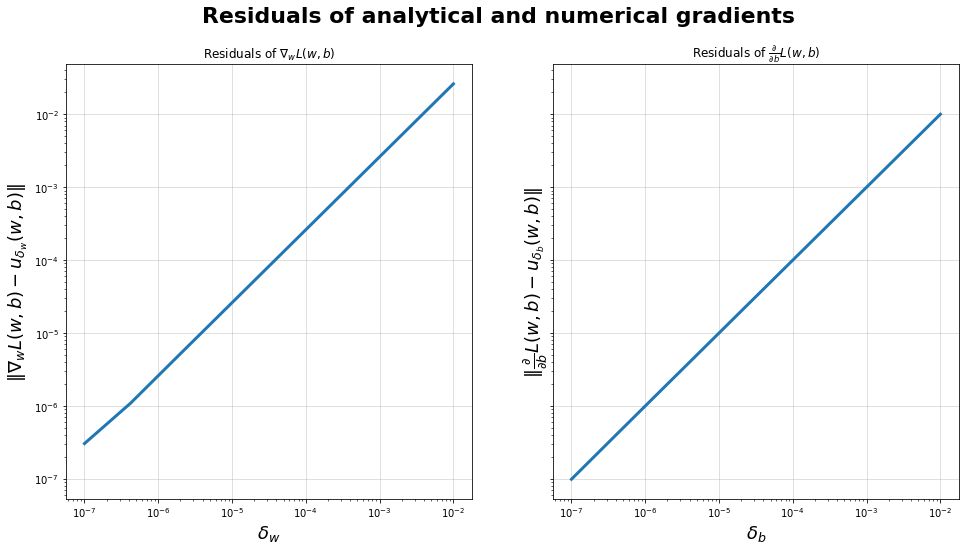

In [7]:
X_train, X_test = train_test_split(dataset, test_size=0.20, random_state=11)

X_val, y_val = prepare.prepare_data(X_test, X_train)
X_train, y_train = prepare.prepare_data(X_train, X_train)

compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))

Q5

In [8]:
def test_lr(X_train, y_train, X_val, y_val, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5)

  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 0.10524575341310104, Best validation loss = 0.10775324721741854
lr size = 1e-08, Best train loss = 0.10523191035474784, Best validation loss = 0.1077389734237164
lr size = 1e-07, Best train loss = 0.10509360084955409, Best validation loss = 0.10759635911759598
lr size = 1e-06, Best train loss = 0.10372254235607394, Best validation loss = 0.10618250685745059
lr size = 1e-05, Best train loss = 0.09114739479706259, Best validation loss = 0.09320386369638821
lr size = 0.0001, Best train loss = 0.0329415105687998, Best validation loss = 0.032670241165981335
lr size = 0.001, Best train loss = 0.014096935550524601, Best validation loss = 0.014106869386962116
lr size = 0.01, Best train loss = 0.008305688059443064, Best validation loss = 0.012779986569138889
lr size = 0.1, Best train loss = 0.007557551994325031, Best validation loss = 0.012720240710459138


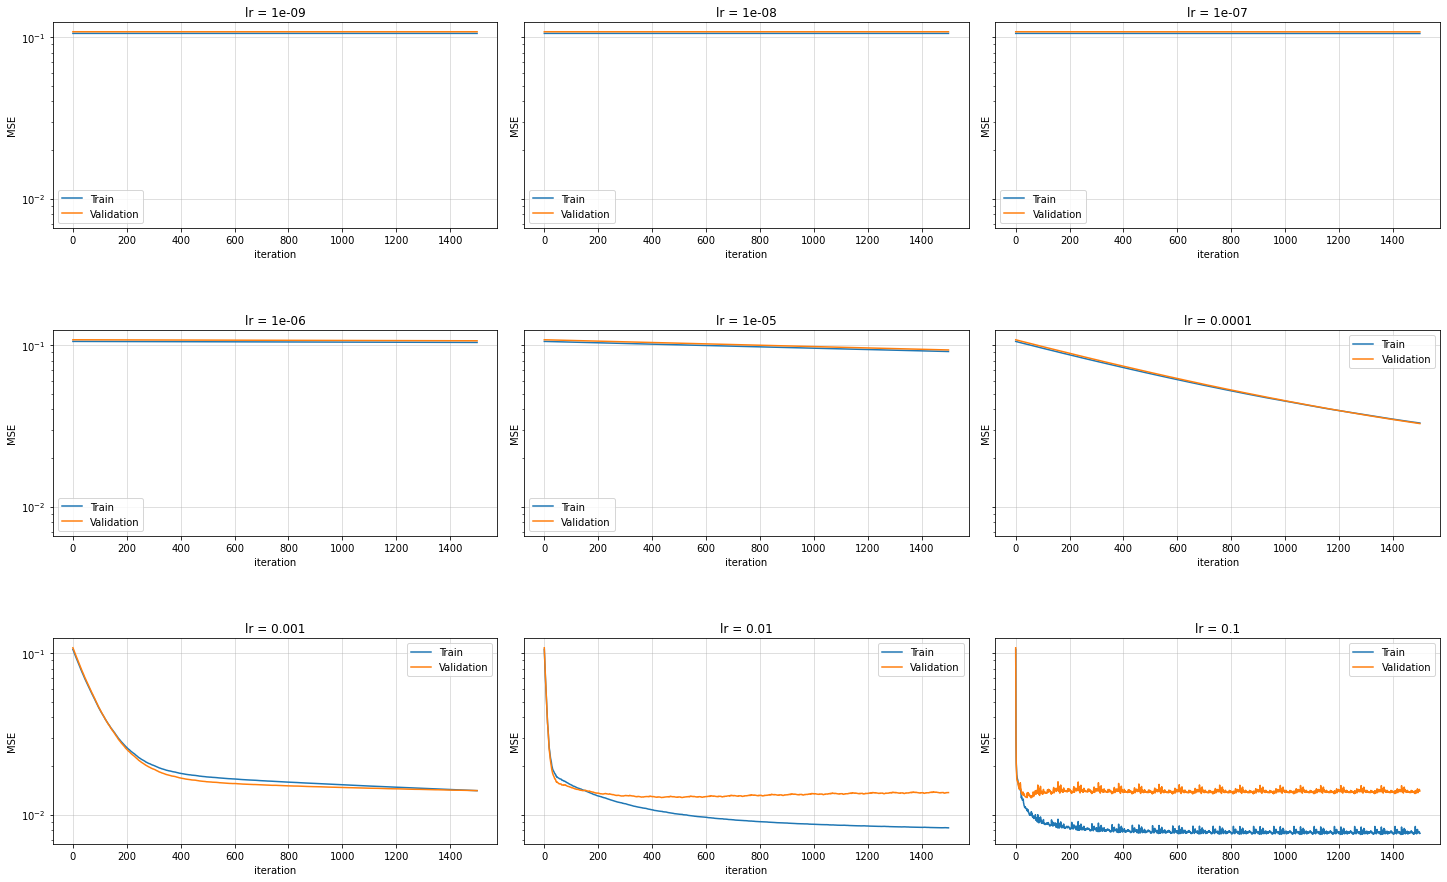

In [9]:
test_lr(X_train, y_train, X_val, y_val)

Section 3
Q6

In [10]:
dummy_reg = DummyRegressor()
scores = cross_validate(dummy_reg, prepared_train, prepared_train_target,
                        cv=5, scoring='neg_mean_squared_error',
                        return_train_score=True)
dummy_train_MSE = np.mean(scores["train_score"])
dummy_val_MSE = np.mean(scores["test_score"])
print(dummy_train_MSE,dummy_val_MSE)

-0.020521603396267362 -0.020533468739149307


Section 4
Q7

Ridge(alpha=1.4149912974345789)

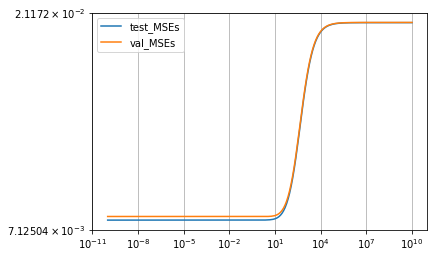

In [11]:
def cross_val_tuning(estimator,X,y,alpha_range):
    test_MSEs = []
    val_MSEs = []
    best_alpha = alpha_range[0]
    for a in alpha_range:
        scores = cross_validate(estimator(fit_intercept=True, alpha=a), X, y,
                                return_train_score=True, scoring="neg_mean_squared_error", cv=5)
        curr_val_MSE = -1 * scores["test_score"].mean()
        curr_train_MSE = -1 * scores["train_score"].mean()
        if val_MSEs != [] and curr_val_MSE < np.amin(val_MSEs):
            best_alpha = a
        test_MSEs.append(curr_train_MSE)
        val_MSEs.append(curr_val_MSE)
    plt.plot(alpha_range, test_MSEs,label="test_MSEs")
    plt.plot(alpha_range, val_MSEs,label="val_MSEs")
    plt.yscale("symlog")
    plt.xscale("log")
    plt.legend()
    plt.grid()
    return best_alpha

best_ridge_alpha = cross_val_tuning(Ridge, prepared_train, prepared_train_target, np.logspace(-10, 10, 200))
ridge_reg = Ridge(fit_intercept=True, alpha=best_ridge_alpha)
scores = cross_validate(ridge_reg, prepared_train, prepared_train_target, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
ridge_train_MSE = -1*np.mean(scores["train_score"])
ridge_val_MSE = -1*np.mean(scores["test_score"])
ridge_reg.fit(prepared_train,prepared_train_target)

Q9-Q10

             attribute  coefficient
0  shortness_of_breath     0.258841
1               PCR_08     0.209231
2      num_of_siblings     0.164967
3                fever     0.120986
4           blood_type     0.092320


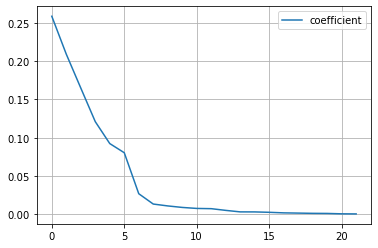

In [12]:
train_coef_by_size = pd.DataFrame({"attribute": prepared_train.columns,"coefficient": np.abs(ridge_reg.coef_)})
train_coef_sorted = train_coef_by_size.sort_values(by="coefficient", ascending=False).reset_index(drop=True)
print(train_coef_sorted[:5])
train_coef_sorted.plot(y="coefficient")
plt.grid()
plt.show()

Q11-Q13

Lasso(alpha=0.00021461411978584058)

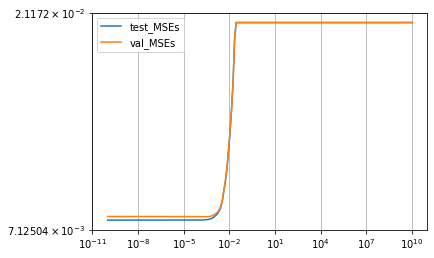

In [13]:
best_lasso_alpha = cross_val_tuning(Lasso, prepared_train, prepared_train_target, np.logspace(-10, 10, 200))
lasso_reg = Lasso(fit_intercept=True, alpha=best_lasso_alpha)
scores = cross_validate(lasso_reg, prepared_train, prepared_train_target, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
lasso_train_MSE = -1*np.mean(scores["train_score"])
lasso_val_MSE = -1*np.mean(scores["test_score"])
lasso_reg.fit(prepared_train,prepared_train_target)

Q14-Q15

             attribute  coefficient
0  shortness_of_breath     0.261606
1               PCR_08     0.204436
2      num_of_siblings     0.162733
3                fever     0.119409
4           blood_type     0.091867


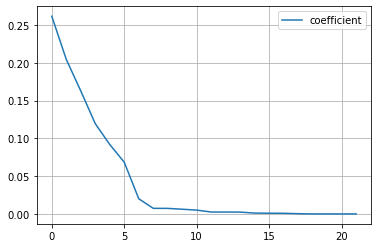

In [14]:
train_coef_by_size = pd.DataFrame({"attribute": prepared_train.columns,"coefficient": np.abs(lasso_reg.coef_)})
train_coef_sorted = train_coef_by_size.sort_values(by="coefficient", ascending=False).reset_index(drop=True)
print(train_coef_sorted[:5])
train_coef_sorted.plot(y="coefficient")
plt.grid()
plt.show()

experiment with coefficients

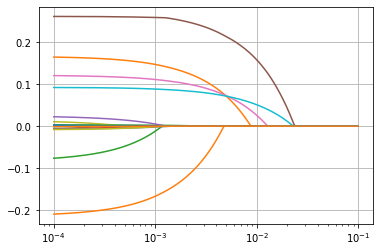

In [15]:
def plot_coefficients_for_parameter_range(estimator,X,y,alpha_range):
    coefficients = []
    for a in alpha_range:
        reg = estimator(fit_intercept=True, alpha=a)
        reg.fit(X,y)
        coefficients.append(reg.coef_)
    plt.plot(alpha_range, coefficients)
    plt.xscale("log")
    plt.grid()

plot_coefficients_for_parameter_range(Lasso, prepared_train, prepared_train_target, np.logspace(-4, -1, 200))

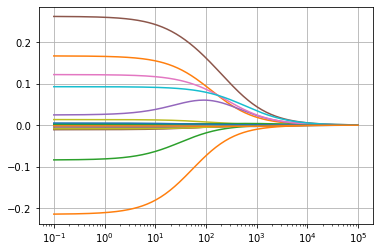

In [16]:
plot_coefficients_for_parameter_range(Ridge, prepared_train, prepared_train_target, np.logspace(-1, 5, 200))

Q16-Q19

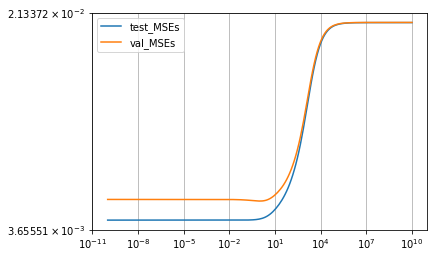

In [17]:
poly = PolynomialFeatures(2, interaction_only=True)
prepared_train_poly = poly.fit_transform(prepared_train)
prepared_test_poly = poly.fit_transform(prepared_test)
best_poly_ridge_alpha = cross_val_tuning(Ridge, prepared_train_poly, prepared_train_target, np.logspace(-10, 10, 200))

In [18]:
poly_ridge_reg = Ridge(fit_intercept=True, alpha=best_poly_ridge_alpha)
scores = cross_validate(poly_ridge_reg, prepared_train_poly, prepared_train_target, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
poly_ridge_train_MSE = -1*np.mean(scores["train_score"])
poly_ridge_val_MSE = -1*np.mean(scores["test_score"])
poly_ridge_reg.fit(prepared_train_poly,prepared_train_target)

Ridge(alpha=0.8907354638610459)

In [19]:
ridge_test_mse = mean_squared_error(prepared_test_target, ridge_reg.predict(prepared_test))
lasso_test_mse = mean_squared_error(prepared_test_target, lasso_reg.predict(prepared_test))
ridge_poly_test_mse = mean_squared_error(prepared_test_target, poly_ridge_reg.predict(prepared_test_poly))
print(f"ridge train MSE: {ridge_train_MSE}")
print(f"ridge val MSE: {ridge_val_MSE}")
print(f"ridge test MSE: {ridge_test_mse}")
print(f"poly ridge train MSE: {poly_ridge_train_MSE}")
print(f"poly ridge val MSE: {poly_ridge_val_MSE}")
print(f"poly ridge test MSE: {ridge_poly_test_mse}")
print(f"lasso train MSE: {lasso_train_MSE}")
print(f"lasso val MSE: {lasso_val_MSE}")
print(f"lasso test MSE: {lasso_test_mse}")

ridge train MSE: 0.007765932979620441
ridge val MSE: 0.007995516291073085
ridge test MSE: 0.007243148127964695
poly ridge train MSE: 0.004541176982951959
poly ridge val MSE: 0.006009696756271313
poly ridge test MSE: 0.004932237387693902
lasso train MSE: 0.007777824106564826
lasso val MSE: 0.007984479473407052
lasso test MSE: 0.007211369904548873
